In [1]:
import matplotlib.pyplot as plt
import numpy as np
import stan
import nest_asyncio
nest_asyncio.apply()
import pandas as pd
from scipy import stats
from scipy.special import softmax
from datetime import datetime
import time
import pickle 
#import json
from scipy.stats import dirichlet, beta

In [2]:
def cumulative(a,b):
    if len(a) != len(b): 
        print('Lengths do not match')
        return
    out = []
    for i in range(len(a)):
        out.append(np.dot(a[:i+1],b[:i+1]))
    return out

def cumulative2(a,b):
    if len(a) != len(b): 
        print('Lengths do not match')
        return
    out = []
    for i in range(len(a)):
        out.append(sum(a[:i+1]) + sum(b[:i+1]))
    return out

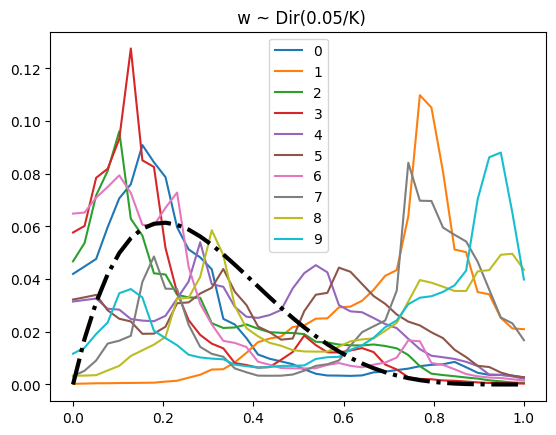

In [3]:
#Yuling
K=40
x = np.linspace(0,1,K)
alpha0 = beta.pdf(x,2,5)
for l in range(10):
    #w = dirichlet.rvs([0.05]*K)[0]
    alpha = [1/K]*K   #PARAMETROS DE LA DIRICHLET TODOS EN 0.05/K
    #alpha = [0.1] * K    
    w = dirichlet.rvs(alpha)[0]   #Weights de la dirichlet
    a = abs(np.random.normal(0,0.3,K-1))   #Genero K-1 valores de una distribución normal con media 0 y desviación estándar 0.5, 
                                           #y tomo el valor abs de estos. Lo voy a meter luego en logp. 

    p0 = [0]*K   #Se va a ir acumulando.
    
    for k in range(K):
        sign = [-1]*(K-1)
        if k>0:
            sign[:k-1] = [1]*(k-1)
        logp = [0] + cumulative(sign,a)
        t = softmax(logp) * w[k]
        p0 = [sum(x) for x in zip(p0, t)]   # sums two vectors element-se    #esto es la funcion densidad de probabilidad
        #print(sign)
    plt.plot(x,p0,label=l)
plt.plot(x,[x/K for x in alpha0],'-.',color='black',linewidth=3)
plt.title(' w ~ Dir(0.05/K)')
plt.legend()
plt.show()

In [50]:
my_model="""
data {
  int<lower=1> K;               // Número de puntos
  vector[K] x;                  // Puntos en el eje x
  vector[K] beta_data;          // Datos reales de la distribución Beta
  vector<lower=0>[K] muj;       // Valor central del prior para la distribución beta
}

parameters {
  simplex[K] w;                 // Pesos de la Dirichlet
  vector<lower=0>[K-1] a;       // Parámetros de la Normal
}

transformed parameters {
  vector[K] p0;                 // Distribución aproximada
  vector[K-1] sign;             // Signos para la combinación
  vector[K] logp;               // Log-probabilidades
  
  sign = rep_vector(-1.0, K-1);
  p0 = rep_vector(0.0, K);
  
  for (k in 1:K) {
    if (k > 1) {
      for (j in 1:(k-1)) {
        sign[j] = 1.0;
      }
    }
    logp[1] = 0.0;
    for (j in 2:K) {
      logp[j] = logp[j-1] + sign[j-1] * a[j-1];
    }
    p0 += softmax(logp) * w[k];
  }
}

model {
  a ~ normal(0, 0.3);            // Priors para los parámetros de la Normal
  w ~ dirichlet(muj .* rep_vector(1.0/K, K));  // Prior para los pesos de la Dirichlet. 
  
  
  // Verosimilitud
  target += beta_data' * log(p0);

}


In [85]:
muj = alpha0+0.0001 #PRIOR DE LA DISTRIBUCION, NOS DICE DÓNDE ESTÁ EL MODO.

In [86]:
# Construyo y ajusto el modelo
model = stan.build(my_model, data= {'K': K, 'x':x, 'beta_data':alpha0/K, 'muj':muj}, random_seed=33)
fit = model.sample(num_chains=5, num_samples=1000)
df = fit.to_frame()

Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   0% (5/10000)
Sampling:   1% (104/10000)
Sampling:   3% (303/10000)
Sampling:   6% (602/10000)
Sampling:   7% (702/10000)
Sampling:   8% (801/10000)
Sampling:  10% (1000/10000)
Sampling:  13% (1300/10000)
Sampling:  15% (1500/10000)
Sampling:  18% (1800/10000)
Sampling:  21% (2100/10000)
Sampling:  22% (2200/10000)
Sampling:  25% (2500/10000)
Sampling:  27% (2700/10000)
Sampling:  42% (4200/10000)
Sampling:  58% (5800/10000)
Sampling:  75% (7500/10000)
Sampling:  87% (8700/10000)
Sampling:  93% (9300/10000)
Sampling:  94% (9400/10000)
Sampling:  95% (9500/10000)
Sampling:  96% (9600/10000)
Sampling:  99% (9900/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received duri

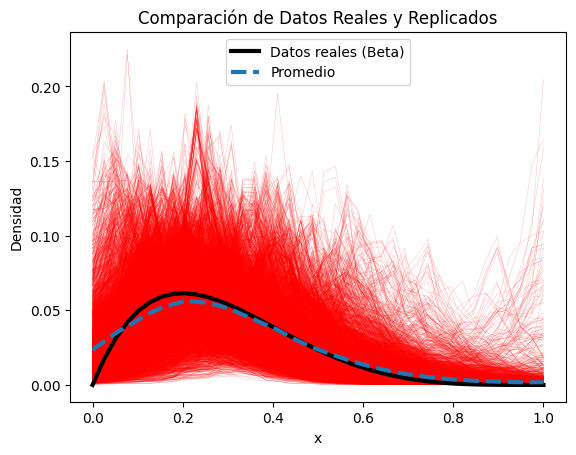

In [87]:
# Obtener los datos replicados del ajuste
replicated_p0 = fit['replicated_p0']

# Calcular la media a lo largo del eje de las muestras replicadas
replicated_p0_mean = np.mean(replicated_p0, axis=1)

# Graficar los datos reales y replicados

for i in range(len(replicated_p0.T)):
    plt.plot(x, replicated_p0.T[i], 'r-', lw=0.2,alpha=0.4)
plt.plot(x, alpha0 / K, 'k-', lw=3, label='Datos reales (Beta)')
plt.plot(x,replicated_p0_mean,lw =3, ls = '--',label='Promedio de inferidos')
plt.title('Comparación de Datos Reales y Replicados')
plt.xlabel('x')
plt.ylabel('Densidad')
plt.legend()
plt.show()

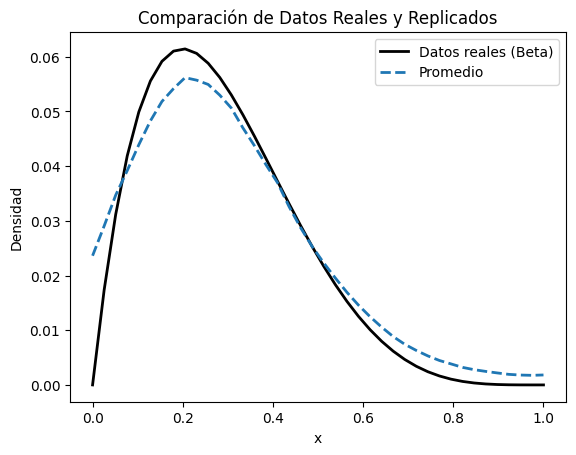

In [88]:
plt.plot(x, alpha0 / K, 'k-', lw=2, label='Datos reales (Beta)')
plt.plot(x,replicated_p0_mean,lw =2, ls = '--',label='Promedio')
plt.title('Comparación de Datos Reales y Replicados')
plt.xlabel('x')
plt.ylabel('Densidad')
plt.legend()
plt.show()

Vamos a probar con una mixtura ahora en 1D.